In [1]:
# !pip install gdown

In [2]:
# !pip  install transformers==4.22.1 -q
!pip install accelerate -U

In [3]:
import transformers

In [4]:
print(transformers.__version__)

4.39.3


In [5]:
from transformers import DistilBertTokenizer
from transformers import DistilBertForSequenceClassification
from transformers import TextClassificationPipeline
from transformers import Trainer, TrainingArguments, EarlyStoppingCallback

import itertools
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset
from transformers import AutoModelForSequenceClassification, AutoTokenizer, Trainer, TrainingArguments, EarlyStoppingCallback
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

2024-05-09 08:27:04.781927: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-09 08:27:04.781988: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-09 08:27:04.783596: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [6]:
import warnings
warnings.filterwarnings("ignore")

In [7]:
# https://docs.google.com/spreadsheets/d/1tuS2I88ThAhfCrsWBViMvg3ISzB8qH9d/edit?usp=sharing&ouid=106084234409314675893&rtpof=true&sd=true

In [8]:
# !gdown --id 1tuS2I88ThAhfCrsWBViMvg3ISzB8qH9d

In [9]:
df = pd.read_excel('Copy of val.xlsx')
df = df[['Tweet','class','Sub']]
df.head()

,Tweet,class,Sub
0,كتبك هي من تسب الآخرين و تصفهم بأقذر الألقاب م...,1,R-HS
1,اخونجي متطرف يعشق الفتنه والخراب لغيره وعشان ك...,1,S-HS
2,احسنت هذا عباله كل واحد عايش في لندن خائن,0,NaN
3,الطيور على أشكالها تقع ، الطغاة يحتفلون بوتين ...,1,P-HS
4,هذا تاريخ الخبيث اللي تروجله ياوهمي متطرف اخون...,1,P-HS


In [10]:
df.shape

(7922, 3)

# Histogram of the count of text

In [11]:
df['count'] = df['Tweet'].apply(lambda x: len(x.split()))

In [12]:
df.head()

,Tweet,class,Sub,count
0,كتبك هي من تسب الآخرين و تصفهم بأقذر الألقاب م...,1,R-HS,22
1,اخونجي متطرف يعشق الفتنه والخراب لغيره وعشان ك...,1,S-HS,15
2,احسنت هذا عباله كل واحد عايش في لندن خائن,0,NaN,9
3,الطيور على أشكالها تقع ، الطغاة يحتفلون بوتين ...,1,P-HS,10
4,هذا تاريخ الخبيث اللي تروجله ياوهمي متطرف اخون...,1,P-HS,17


In [13]:
np.max(df['count'])

62

<Figure size 800x800 with 0 Axes>

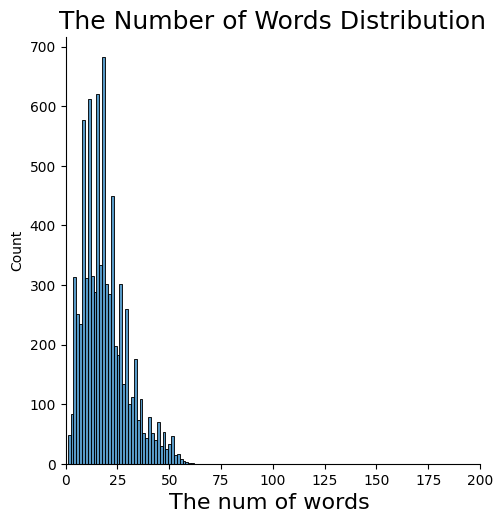

In [14]:
plt.figure(figsize= (8, 8))

sns.displot(df['count'])

plt.xlim(0, 200)

plt.xlabel('The num of words ', fontsize = 16)
plt.title("The Number of Words Distribution", fontsize = 18)
plt.show()



# Bar plot for each category

In [15]:
category_count = df['class'].value_counts()
categories  = df['class'].unique()

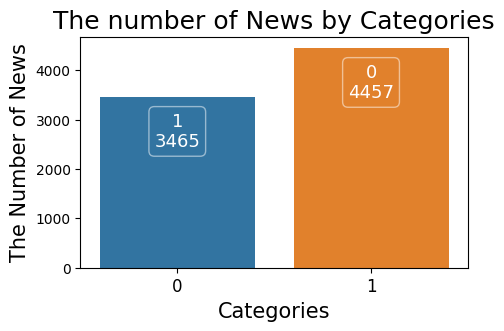

In [16]:
fig = plt.figure(figsize= (5, 3))

ax = fig.add_subplot(111)

sns.barplot(x = category_count.index, y = category_count )

for a, p in enumerate(ax.patches):
    ax.annotate(f'{categories[a]}\n' + format(p.get_height(), '.0f'), xy = (p.get_x() + p.get_width() / 2.0, p.get_height()), xytext = (0,-25), size = 13, color = 'white' , ha = 'center', va = 'center', textcoords = 'offset points', bbox = dict(boxstyle = 'round', facecolor='none',edgecolor='white', alpha = 0.5) )

plt.xlabel('Categories', size = 15)

plt.ylabel('The Number of News', size= 15)

plt.xticks(size = 12)

plt.title("The number of News by Categories" , size = 18)

plt.show()

In [17]:
data_texts = df['Tweet'].to_list()
data_labels = df['class'].to_list()

# Helper Functions

In [18]:

# Define the TweetDataset class
class TweetDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [19]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    accuracy = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average='macro')
    precision = precision_score(labels, preds, average='macro')
    recall = recall_score(labels, preds, average='macro')
    return {
        'accuracy': accuracy,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

# Function to plot confusion matrix
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Model Definition

In [20]:
model_name = 'aubmindlab/bert-large-arabertv02-twitter'

In [21]:
from transformers import AutoTokenizer, AutoModel
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Fine-tuning with the TFTrainer class

In [22]:
# Stratified K-Fold setup
labels = df['class'].values  # Notice the leading space in ' class'
skf = StratifiedKFold(n_splits=5)

In [23]:
# Clear output folder
import os

def remove_folder_contents(folder):
    for the_file in os.listdir(folder):
        file_path = os.path.join(folder, the_file)
        try:
            if os.path.isfile(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                remove_folder_contents(file_path)
                os.rmdir(file_path)
        except Exception as e:
            print(e)


In [24]:
import os
os.environ["WANDB_DISABLED"] = "true"

Fold 1


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at aubmindlab/bert-large-arabertv02-twitter and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.264224,0.888959,0.888264,0.887340,0.893136
2,0.384000,0.265730,0.913565,0.912510,0.911298,0.914192
3,0.159400,0.376512,0.914196,0.912366,0.915019,0.910407
4,0.069900,0.432247,0.916088,0.914500,0.915846,0.913376


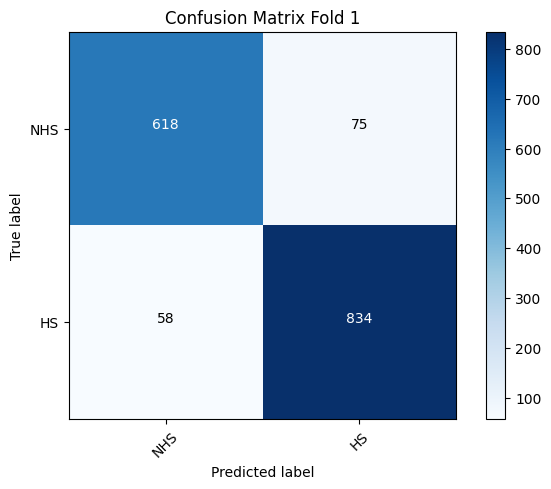

              precision    recall  f1-score   support

         NHS       0.91      0.89      0.90       693
          HS       0.92      0.93      0.93       892

    accuracy                           0.92      1585
   macro avg       0.92      0.91      0.91      1585
weighted avg       0.92      0.92      0.92      1585

Fold 2


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at aubmindlab/bert-large-arabertv02-twitter and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.249684,0.896530,0.895253,0.894127,0.896804
2,0.381400,0.261978,0.911041,0.909688,0.909376,0.910019
3,0.158200,0.398670,0.903470,0.902373,0.901040,0.904419
4,0.057400,0.455422,0.911672,0.909985,0.911408,0.908809


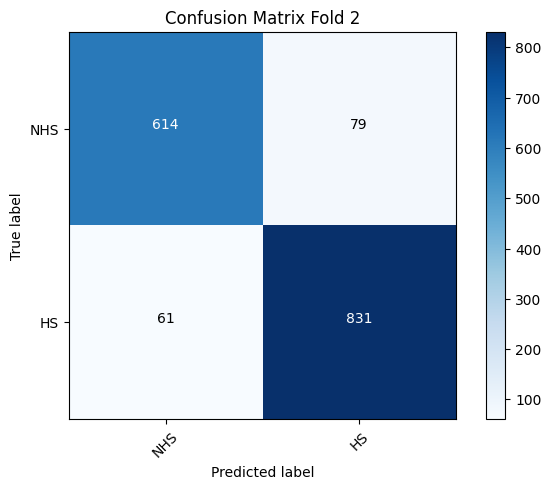

              precision    recall  f1-score   support

         NHS       0.91      0.89      0.90       693
          HS       0.91      0.93      0.92       892

    accuracy                           0.91      1585
   macro avg       0.91      0.91      0.91      1585
weighted avg       0.91      0.91      0.91      1585

Fold 3


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at aubmindlab/bert-large-arabertv02-twitter and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.297104,0.885101,0.881395,0.891252,0.876704
2,0.374500,0.261594,0.904672,0.902135,0.908198,0.898589
3,0.155200,0.421026,0.905303,0.903738,0.904008,0.903479
4,0.044900,0.496062,0.900884,0.899093,0.900046,0.898268


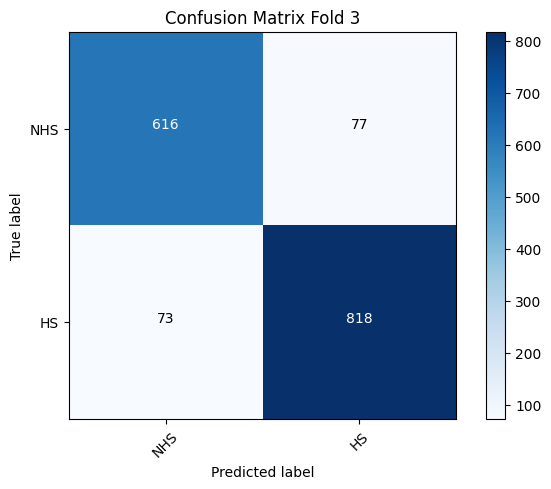

              precision    recall  f1-score   support

         NHS       0.89      0.89      0.89       693
          HS       0.91      0.92      0.92       891

    accuracy                           0.91      1584
   macro avg       0.90      0.90      0.90      1584
weighted avg       0.91      0.91      0.91      1584

Fold 4


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at aubmindlab/bert-large-arabertv02-twitter and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.326538,0.886995,0.881900,0.902816,0.874699
2,0.382900,0.264703,0.907197,0.905739,0.905675,0.905804
3,0.146600,0.392477,0.907828,0.906568,0.905795,0.907488
4,0.040500,0.486018,0.912879,0.911165,0.912969,0.909732


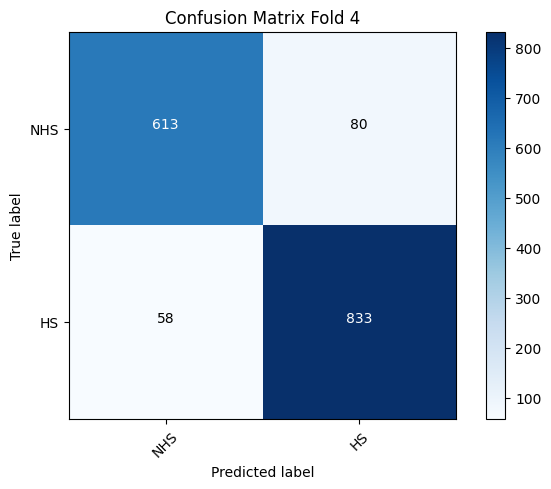

              precision    recall  f1-score   support

         NHS       0.91      0.88      0.90       693
          HS       0.91      0.93      0.92       891

    accuracy                           0.91      1584
   macro avg       0.91      0.91      0.91      1584
weighted avg       0.91      0.91      0.91      1584

Fold 5


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at aubmindlab/bert-large-arabertv02-twitter and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.258945,0.900253,0.897222,0.905971,0.892737
2,0.378700,0.280996,0.897096,0.896472,0.895565,0.901475
3,0.150700,0.424991,0.904672,0.903651,0.902248,0.905964
4,0.040600,0.456000,0.916667,0.914872,0.917758,0.912779


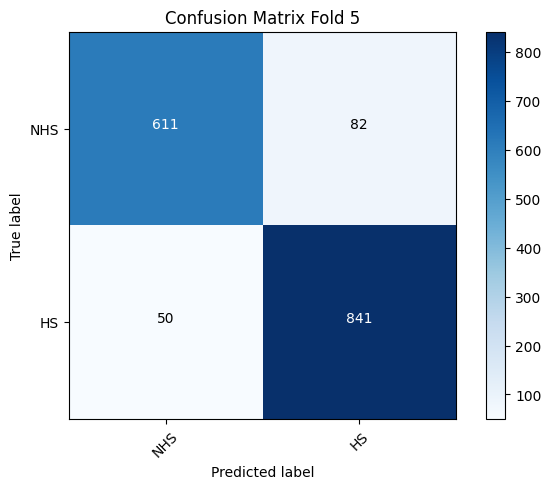

              precision    recall  f1-score   support

         NHS       0.92      0.88      0.90       693
          HS       0.91      0.94      0.93       891

    accuracy                           0.92      1584
   macro avg       0.92      0.91      0.91      1584
weighted avg       0.92      0.92      0.92      1584



In [25]:
# DataFrame to store results
results_df = pd.DataFrame(columns=['Fold', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])

# Loop through the folds
for fold, (train_idx, val_idx) in enumerate(skf.split(df.index, labels)):
    print(f'Fold {fold + 1}')
    fold_results = []

    # Split the data
    train_texts = df.iloc[train_idx]['Tweet'].tolist()
    val_texts = df.iloc[val_idx]['Tweet'].tolist()
    train_labels = labels[train_idx]
    val_labels = labels[val_idx]
    val_subs = df.iloc[val_idx]['Sub'].tolist()

    # Tokenize the data
    train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=128)
    val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=128)

    # Create datasets
    train_dataset = TweetDataset(train_encodings, train_labels)
    val_dataset = TweetDataset(val_encodings, val_labels)


    # Define the TrainingArguments inside the loop to use 'fold'
    training_args = TrainingArguments(
        output_dir=f'training_results_fold_{fold + 1}',
        num_train_epochs=4,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        warmup_steps=500,
        weight_decay=0.01,
        logging_dir=f'/content/logs_fold_{fold + 1}',
        evaluation_strategy='epoch',
        save_strategy='epoch',
        load_best_model_at_end=True,
        metric_for_best_model='accuracy',
        greater_is_better=True,
        learning_rate=2e-5,
    )
    # Initialize the model for each fold
    # model = DistilBertForSequenceClassification.from_pretrained(model_name, num_labels = 2)
    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels = 2)

    # Initialize the Trainer with EarlyStoppingCallback for each fold
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics,
        # callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
    )

    # Train the model
    trainer.train()

    # Evaluate the best model on the validation set
    eval_result = trainer.evaluate()
    accuracy = eval_result['eval_accuracy']
    f1 = eval_result['eval_f1']
    precision = eval_result['eval_precision']
    recall = eval_result['eval_recall']

    # Store the results for this fold
    fold_results.append([fold, accuracy, precision, recall, f1])

    # Compute confusion matrix and plot
    preds = np.argmax(trainer.predict(val_dataset)[0], axis=1)
    cm = confusion_matrix(val_labels, preds)
    plot_confusion_matrix(cm, classes=['NHS', 'HS'], title=f'Confusion Matrix Fold {fold + 1}')

    print(classification_report(val_labels, preds, target_names=['NHS', 'HS']))

    # Prepare DataFrame with validation set tweets, true labels, predicted labels, and save
    val_df = pd.DataFrame({
        'Tweet': val_texts,
        'True Label': val_labels,
        'Predicted Label': preds,
        'Sub': val_subs
    })
    val_df.to_excel(f'/kaggle/working/arabert_val_set_with_preds_fold_{fold + 1}.xlsx', index=False)

    folder_path = f'/kaggle/working/training_results_fold_{fold+1}'
    remove_folder_contents(folder_path)
    os.rmdir(folder_path)
# Append fold results to the DataFrame
results_df = pd.concat([results_df, pd.DataFrame(fold_results, columns=results_df.columns)], ignore_index=True)

In [26]:
# Calculate average metrics across all folds for this model
avg_accuracy = np.mean(results_df['Accuracy'])
avg_precision = np.mean(results_df['Precision'])
avg_recall = np.mean(results_df['Recall'])
avg_f1 = np.mean(results_df['F1 Score'])


print(f'Average Accuracy: {avg_accuracy:.4f}')
print(f'Average Precision: {avg_precision:.4f}')
print(f'Average Recall: {avg_recall:.4f}')
print(f'Average F1 Score: {avg_f1:.4f}')
print('')

Average Accuracy: 0.9167
Average Precision: 0.9178
Average Recall: 0.9128
Average F1 Score: 0.9149



In [32]:
results_df.to_csv('arabert.csv', index=False)

# Inferencing with Pytorch

In [27]:
text1 = 'الأفكار التي تحرض على كراهية الجنس دون الآخر هي أفكار شاذة ولا تجوز شرعاً ومن سمح بذلك فهو أما جاهل أو أحمق'
text2 = 'اكيد كويتي تربيته من شغاله و تعليمه من سواق ما راح يفهم لو جبت له احصائيات البنك'
text3 = 'أردتَ إثارة الجدل ففعلت ولكن أثبت أنك مهان وتحب الإهانات'

In [28]:
predict_input_pt = tokenizer(text1, truncation = True, padding = True, return_tensors = 'pt' ).to('cuda')
ouput_pt = model(predict_input_pt['input_ids'])
prediction_value_pt = torch.argmax(ouput_pt[0], dim = 1 ).item()

prediction_value_pt

0

In [29]:
predict_input_pt = tokenizer(text2, truncation = True, padding = True, return_tensors = 'pt' ).to('cuda')
ouput_pt = model(predict_input_pt['input_ids'])
prediction_value_pt = torch.argmax(ouput_pt[0], dim = 1 ).item()

prediction_value_pt

1

In [30]:
predict_input_pt = tokenizer(text3, truncation = True, padding = True, return_tensors = 'pt' ).to('cuda')
ouput_pt = model(predict_input_pt['input_ids'])
prediction_value_pt = torch.argmax(ouput_pt[0], dim = 1 ).item()

prediction_value_pt

1